# Today you are a Machine Learning Engineer at Walmart!
For your latest assignemt, your manager has asked your team to work alongside the Data Engineering team to design an optimal Machine Learning pipeline for Automated Inventory. The Data Engineering team has used Trifacta to clean some online shopping data gathered from the servers over the last few months. You are expected to report back the following to your manager:
1. What are some behavoural categories of customers? Can you see some patterns from the shopping behaviors?
2. What are some biases that need to be addressed for predictive modeling?
3. Design a best predictive model and deploy it.
4. How would you monitor changes to behavoural categories?

### This assignment is based on the work in: https://arxiv.org/pdf/2102.01625.pdf
Additional Code and explanations available at: https://github.com/sohiniroych/Volvo-DataX/blob/master/User%20Journey%20Modeling/Cosmetics_Journey.ipynb

### In this assignment, we will read client data that has been pre-processed (using Trifacta), and stored in an S3 bucket name "mlops-ecommerce". Working off the S3 bucket directly allows you freedom to work from any workstation and also to maintain teh integrity of the data sensitivity (no need to download on system).

In [ ]:
## Start with loading the Libraries and loading the data
import boto3
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

## For this work, the data from "mlops-ecommerce" bucket will be accessed using boto3! The next step will take about 5-10 mins to load since the data is large!

In [ ]:
role = get_execution_role()
bucket='mlops-ecommerce'
data_key = 'Cosmetics_Journey_25.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

raw_data=pd.read_csv(data_location)

In [1]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb

In [2]:
raw_data = pd.read_csv("Cosmetics_Journey_25.csv")

np.shape(raw_data)

(2500000, 36)

In [3]:
# print first few rows of the data
dat1=raw_data.iloc[:,2:13]
dat1.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,InsessionRemove
0,2,2,1768258.0,2.06,2.06,1,0,0,14,6,15
1,1,1,0.0,3.97,3.97,0,1,0,0,1,0
2,1,1,0.0,9.52,9.52,0,1,0,0,1,0
3,1,1,0.0,19.84,19.84,0,1,0,0,1,0
4,4,1,3865.0,5.43,5.43,1,1,2,39,46,26


### So you see the Data Engineering team has sent you 2.5M records corresponding to users and their interations with products. Notice two things:
1. All features are nuumeric (so one-hot-encoding has been done).
2. Last column depicts if the user-product interation resulted in a purchase or not.
Such kind of data is referred to as "User Journeys". This work is based on the recent paper: https://arxiv.org/pdf/2102.01625.pdf

# Task 1: Perform Exploratory Data Analysis (EDA) to find features that are important. You can use any method of choice. Example RandomForestClassifier for feature importance https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [4]:
#Load Libraries for Data splitting and normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import seaborn as sn

In [5]:
XData = raw_data.iloc[:,2:-1]
YData = raw_data.iloc[:,-1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42, stratify=YData)

In [7]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

In [8]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 10))

In [9]:
sel.fit(X_train[:20000,:], y_train[:20000])

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10))

In [10]:
selected_feat= XData.columns[(sel.get_support())]

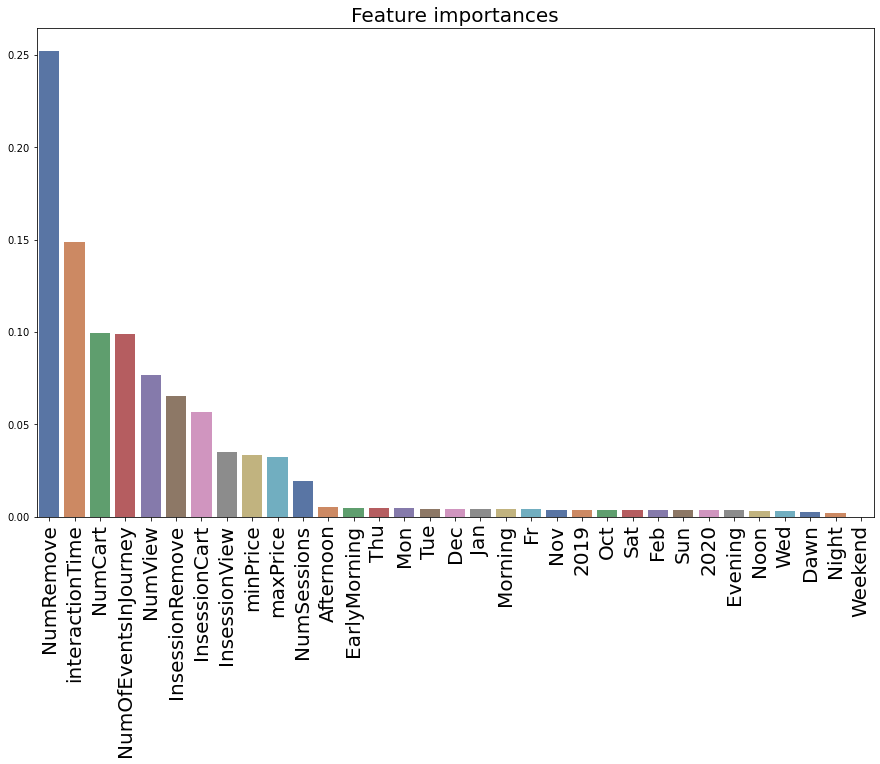

In [11]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sn.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

In [12]:
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

/home/sohini/anaconda3/envs/autotf/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/sohini/anaconda3/envs/autotf/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [13]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

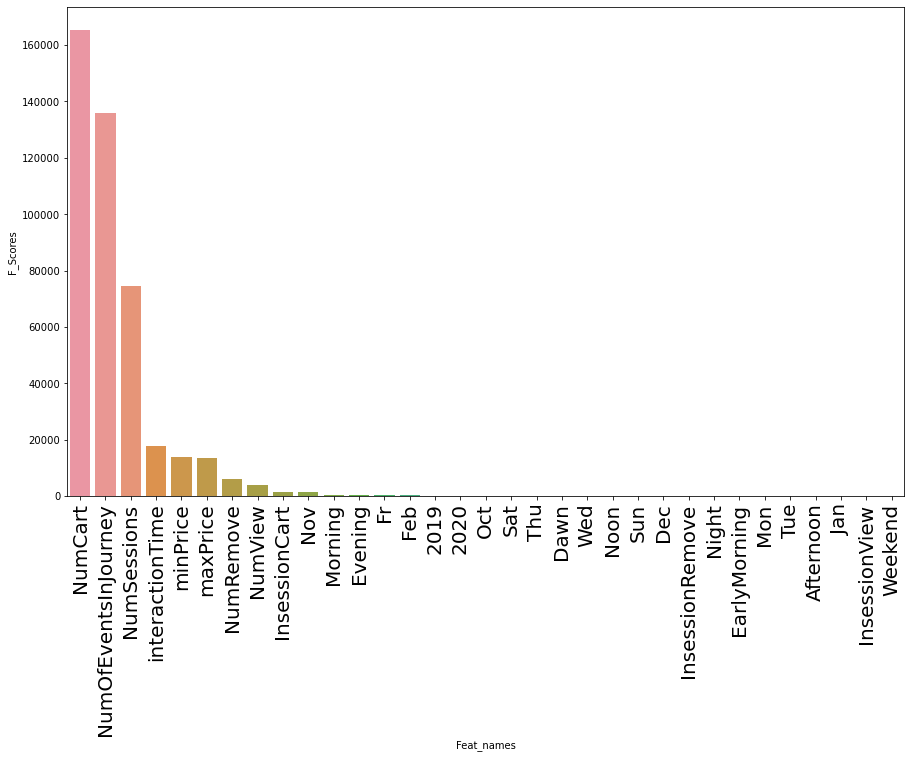

In [14]:
plt.figure(figsize=(15,9))
sn.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

## Thus, we observe that the temporal features (time, day, year etc) have significantly less importance than the other features. Thus, we reduce data dimensionality by discarding the temporal features!

In [15]:
X_train_1=X_train[:,1:13]
X_test_1=X_test[:,1:13]

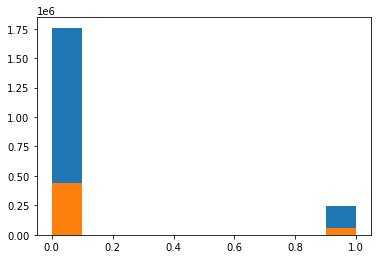

Fraction of Purchases in train data= 0.120671
Fraction of Purchases in test data= 0.12067


In [16]:
# Next lets look at the data distribution
plt.hist(y_train)
plt.hist(y_test)
plt.show()
print("Fraction of Purchases in train data=", np.sum(y_train)/np.shape(y_train)[0])
print("Fraction of Purchases in test data=", np.sum(y_test)/np.shape(y_test)[0])

# Task 2: Build a classifier with hyper-parameter tuning pipeline for the complete data!

### Here, we convert the processed training data to protobuf and write to S3 for linear learner in Sagemaker.

In [ ]:
bucket_new='sohini-mlops-ecommerce'# Add the name of your data bucket here
s3_train_key = "{}/train/recordio-pb-data".format(prefix)
s3_train_path = os.path.join("s3://", bucket_new, s3_train_key)
vectors = np.array([t.tolist() for t in X_train_1]).astype("float32")
labels = np.array([t.tolist() for t in y_train]).astype("float32")
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource("s3").Bucket(bucket).Object(s3_train_key).upload_fileobj(buf)


We will wrap the model training setup in a convenience function that takes in the S3 location of the training data, the model hyperparameters that define our training job, and the S3 output path for model artifacts. Inside the function, we'll hardcode the algorithm container, the number and type of EC2 instances to train on, and the input and output data formats.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri


def predictor_from_hyperparams(s3_train_data, hyperparams, output_path):
    """
    Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor
    """
    # specify algorithm containers and instantiate an Estimator with given hyperparams
    container = get_image_uri(boto3.Session().region_name, "linear-learner")

    linear = sagemaker.estimator.Estimator(
        container,
        role,
        train_instance_count=1,
        train_instance_type="ml.m4.xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    linear.set_hyperparameters(**hyperparams)
    # train model
    linear.fit({"train": s3_train_data})
    # deploy a predictor
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    linear_predictor.content_type = "text/csv"
    linear_predictor.serializer = csv_serializer
    linear_predictor.deserializer = json_deserializer
    return linear_predictor

And add another convenience function for setting up a hosting endpoint, making predictions, and evaluating the model. To make predictions, we need to set up a model hosting endpoint. Then we feed test features to the endpoint and receive predicted test labels. To evaluate the models we create in this exercise, we'll capture predicted test labels and compare them to actuals using some common binary classification metrics.

In [ ]:
def evaluate(linear_predictor, test_features, test_labels, model_name, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  Return binary classification metrics.
    """
    # split the test data set into 100 batches and evaluate using prediction endpoint
    prediction_batches = [
        linear_predictor.predict(batch)["predictions"]
        for batch in np.array_split(test_features, 100)
    ]
    # parse raw predictions json to exctract predicted label
    test_preds = np.concatenate(
        [np.array([x["predicted_label"] for x in batch]) for batch in prediction_batches]
    )

    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1 - test_labels, test_preds).sum()
    tn = np.logical_and(1 - test_labels, 1 - test_preds).sum()
    fn = np.logical_and(test_labels, 1 - test_preds).sum()

    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)

    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=["actuals"], colnames=["predictions"]))
        print("\n{:<11} {:.3f}".format("Recall:", recall))
        print("{:<11} {:.3f}".format("Precision:", precision))
        print("{:<11} {:.3f}".format("Accuracy:", accuracy))
        print("{:<11} {:.3f}".format("F1:", f1))

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1": f1,
        "Model": model_name,
    }

And finally we'll add a convenience function to delete prediction endpoints after we're done with them:

In [22]:
def delete_endpoint(predictor):
    try:
        boto3.client("sagemaker").delete_endpoint(EndpointName=predictor.endpoint)
        print("Deleted {}".format(predictor.endpoint))
    except:
        print("Already deleted: {}".format(predictor.endpoint))

Let's begin by training a binary classifier model with the linear learner default settings. Note that we're setting the number of epochs to 40, which is much higher than the default of 10 epochs. With early stopping, we don't have to worry about setting the number of epochs too high. Linear learner will stop training automatically after the model has converged.

In [ ]:
# Training a binary classifier with default settings: logistic regression
defaults_hyperparams = {"feature_dim": 30, "predictor_type": "binary_classifier", "epochs": 40}
defaults_output_path = "s3://{}/{}/defaults/output".format(bucket_new, prefix)
defaults_predictor = predictor_from_hyperparams(
    s3_train_path, defaults_hyperparams, defaults_output_path
)

In [ ]:
# Training a binary classifier with automated threshold tuning
autothresh_hyperparams = {
    "feature_dim": 30,
    "predictor_type": "binary_classifier",
    "binary_classifier_model_selection_criteria": "precision_at_target_recall",
    "target_recall": 0.9,
    "epochs": 40,
}
autothresh_output_path = "s3://{}/{}/autothresh/output".format(bucket_new, prefix)
autothresh_predictor = predictor_from_hyperparams(
    s3_train_path, autothresh_hyperparams, autothresh_output_path
)

In [ ]:
# Training a binary classifier with class weights and automated threshold tuning
class_weights_hyperparams = {
    "feature_dim": 30,
    "predictor_type": "binary_classifier",
    "binary_classifier_model_selection_criteria": "precision_at_target_recall",
    "target_recall": 0.9,
    "positive_example_weight_mult": "balanced",
    "epochs": 40,
}
class_weights_output_path = "s3://{}/{}/class_weights/output".format(bucket_new, prefix)
class_weights_predictor = predictor_from_hyperparams(
    s3_train_path, class_weights_hyperparams, class_weights_output_path
)

In [ ]:
# Evaluate the trained models
predictors = {
    "Logistic": defaults_predictor,
    "Logistic with auto threshold": autothresh_predictor,
    "Logistic with class weights": class_weights_predictor,
    "Hinge with auto threshold": svm_predictor,
    "Hinge with class weights": svm_balanced_predictor,
}
metrics = {
    key: evaluate(predictor, X_test_1, y_test, key, False)
    for key, predictor in predictors.items()
}
pd.set_option("display.float_format", lambda x: "%.3f" % x)
display(
    pd.DataFrame(list(metrics.values())).loc[:, ["Model", "Recall", "Precision", "Accuracy", "F1"]]
)

# Task 3: Data Clustering
The Data Engineering team further tells you that 5 types of user clusters exist. Can you categorize each user to a separate cluster?

In [23]:
# Next cluster using k-means on the 3 dimensional data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train_1)
kmeans.cluster_centers_.shape

(5, 12)

In [24]:
y_train_CID=kmeans.predict(X_train_1)
y_test_CID=kmeans.predict(X_test_1)
y_test_CID=np.array(y_test_CID)


In [25]:
classes=['0','1','2','3','4']

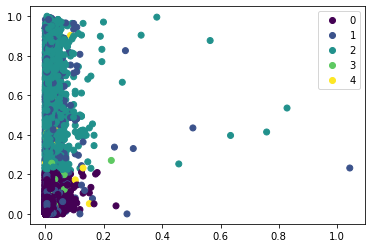

In [20]:
#scatter plot with original data
scatter=plt.scatter(X_test_1[:,0], X_test_1[:,1], c=y_test_CID, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

# Find Rep=#samples in a class/total number of samples, PuR=#purchases/number of entries per class

In [53]:
for item in range(5):
    locs=np.where(y_train_CID==item)
    y_train_sub=np.take(y_train,locs[0])
    Rep=round((len(locs[0])/len(y_train))*100,2)
    PuR=round((np.sum(y_train_sub)/len(locs[0]))*100,2)
    print('For cluster', item, 'Rep=',Rep,'PuR=',PuR)

For cluster 0 Rep= 78.32 PuR= 12.11
For cluster 1 Rep= 14.33 PuR= 12.95
For cluster 2 Rep= 2.66 PuR= 23.49
For cluster 3 Rep= 3.81 PuR= 2.3
For cluster 4 Rep= 0.88 PuR= 1.24


## Our findings are as follows:
1. Cluster label 0 represents the majority customers with similar purchase ratio as complete data set. This cluster is biasing major class. 
2. Cluster label 2 has double purchase ratio than complete data set but very small representation. 
3. Cluster 3 and 4 represent rarely purchasing/non-purchasing customers

# Task 4: Classification per cluster
## Resuing the code from Task 2, Report the best classification performances for the cluster variants
So find teh best classification performances for Cluster label 0, 2 and 3!

## Step 1: Subsample X_train,y_train, X_test, y_test per cluster followed by classification on the data

In [ ]:
#Finally, clean up
for predictor in [
    defaults_predictor,
    autothresh_predictor,
    class_weights_predictor,
    svm_predictor,
    svm_balanced_predictor,
]:
    delete_endpoint(predictor)